<a href="https://colab.research.google.com/github/thelastbeto/Language-Natural-Processing-With-Spark/blob/main/Natural_Language_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=f4e84c0130f217d42fed46d03bf864a4a8f7733d73d875e9a6747cca8d2b5cff
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

In [3]:
dados = spark.read.csv("/content/imdb-reviews-pt-br.csv",
                       escape='\"',
                       header=True,
                       inferSchema=True)

# Explorando os Dados

In [4]:
# tamanho dos dados:
print(f'Número de Linhas:{dados.count()}')
print(f'Número de Colunas:{len(dados.columns)}')

Número de Linhas:49459
Número de Colunas:4


In [5]:
# Campos e tipos
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [6]:
# Conteudo
dados.limit(10).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+



In [7]:
# Retornando comentários negativos e positivos para que possamos visualizar.
resultados1 = dados.filter(dados.id == 190).select("text_pt", "sentiment").collect()
print(f'Isso é um comentário negativo: {resultados1}')
resultados2 = dados.filter(dados.id == 9900).select("text_pt", "sentiment").collect()
print(f'Isso é um comentário positivo: {resultados2}')


Isso é um comentário negativo: [Row(text_pt='Este é sem dúvida o pior filme que eu já vi. E acredite em mim, eu vi muitos filmes. A reviravolta inacreditável que o filme faz - passando de um extremamente mau filme "Formas de vida alienígenas habitam a terra", com um filme que tenta espalhar um arquicristiano "O dia do julgamento está próximo, buscar Jesus ou queimar por toda a eternidade em as dívidas ardentes do inferno "mensagem - deixou-me atordoado depois de ter sido atormentado por 85 minutos. Até mesmo os cristãos religiosos devem se envergonhar ou ficar furiosos ao ver suas crenças postadas dessa maneira. Eu não sabia o que fazer comigo quando assisti a atuação horrível que poderia ter sido realizada por crianças de 7 anos de idade. Simplesmente repugnante. Eu não sou cristão nem muito religioso. Mas se eu estivesse, não teria mais medo do Inferno. Rich Christiano mostrou ser algo muito pior.', sentiment='neg')]
Isso é um comentário positivo: [Row(text_pt='Este filme está lá em 

In [8]:
# Contabilizar o tipo de comentários

dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



# Limpeza e Processamento

## Word Cloud
### Utilizada para entender as palavras mais frequentes de um texto.

In [9]:
from wordcloud import WordCloud as wc
import matplotlib.pyplot as plt

In [10]:
# A nossa amostra vai ser um select do 'text_pt'
amostra = dados.select('text_pt').sample(fraction = 0.1, seed = 101)
tudo = [texto['text_pt'] for texto in amostra.collect()]

In [11]:
wordCloud = wc(background_color = 'white', width = 750, height = 600, prefer_horizontal=1, collocations=False).generate(str(tudo))

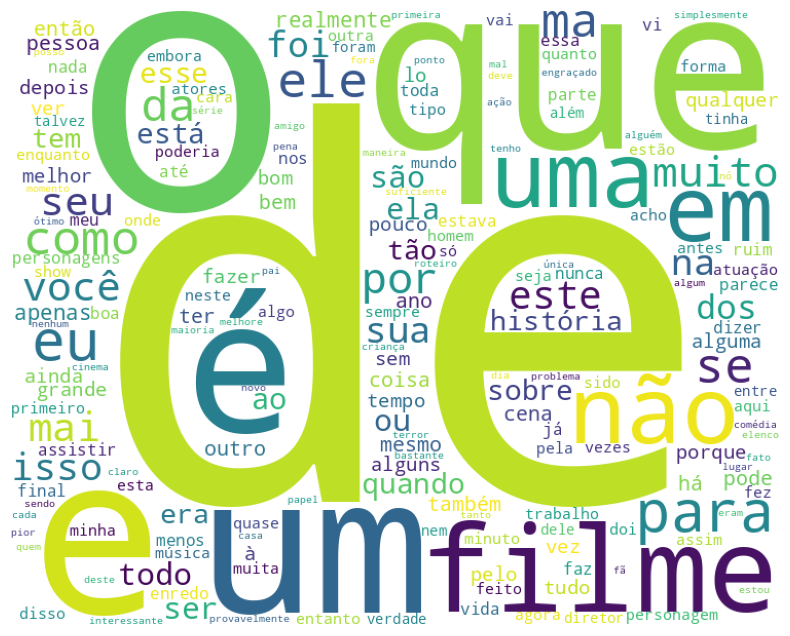

In [12]:
plt.figure(figsize=(20,8))
plt.imshow(wordCloud)
plt.axis("off")
plt.show()

## Limpeza de Caracteres Especiais

In [13]:
# Remoção esses tipos de caracteres
import string
import pyspark.sql.functions as f
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
# retirando os caracteres dos nossos dados
dados = dados.withColumn("texto_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./;:<=>?@^_`´{|}~\\\\]", ""))

In [15]:
dados.limit(5).show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
# tirando os espaços do começo e do final das frases:
# neste caso, poderia ser usado o regex tambem
dados.withColumn("espaço_branco_out", f.trim(dados.texto_regex))
dados = dados.withColumn("espaço_branco_out", f.trim(dados.texto_regex))

In [17]:
dados.limit(5).show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Tokenizacao

In [18]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "espaço_branco_out", outputCol = "tokens")

In [19]:
tokenizado = tokenizer.transform(dados)

In [20]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

countTokens = f.udf(lambda tokens: len(tokens), IntegerType())

tokenizado.select("espaço_branco_out", "tokens")\
.withColumn("Freq_tokens", countTokens(f.col("tokens"))).show()

+--------------------+--------------------+-----------+
|   espaço_branco_out|              tokens|Freq_tokens|
+--------------------+--------------------+-----------+
|Once again Mr Cos...|[once, again, mr,...|        168|
|This is an exampl...|[this, is, an, ex...|        232|
|First of all I ha...|[first, of, all, ...|        215|
|Not even the Beat...|[not, even, the, ...|        308|
|Brass pictures mo...|[brass, pictures,...|        238|
|A funny thing hap...|[a, funny, thing,...|        115|
|This German horro...|[this, german, ho...|        156|
|Being a longtime ...|[being, a, longti...|        136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|        129|
|Wealthy horse ran...|[wealthy, horse, ...|        160|
|Cage plays a drun...|[cage, plays, a, ...|        109|
|First of all I wo...|[first, of, all, ...|        333|
|So tell me  what ...|[so, tell, me, , ...|        243|
|A big disappointm...|[a, big, disappoi...|        110|
|This film is abso...|[this, film, is, ...|     

### StopWords

In [21]:
from pyspark.ml.feature import StopWordsRemover


In [22]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final")

feature_data = remover.transform(tokenizado)


In [23]:
feature_data.select("tokens", "texto_final")\
                    .withColumn("Freq_tokens", countTokens(f.col("tokens")))\
                    .withColumn("Fre_tokens_limpos", countTokens(f.col("texto_final"))).show()

# Adiciona duas novas colunas:
#"Freq_tokens": Contém o número de tokens originais (antes da remoção das stop words).
#"Freq_tokens_limpos": Contém o número de tokens após a remoção das stop words.


+--------------------+--------------------+-----------+-----------------+
|              tokens|         texto_final|Freq_tokens|Fre_tokens_limpos|
+--------------------+--------------------+-----------+-----------------+
|[once, again, mr,...|[mr, costner, dra...|        168|               73|
|[this, is, an, ex...|[example, majorit...|        232|              131|
|[first, of, all, ...|[first, hate, mor...|        215|              111|
|[not, even, the, ...|[even, beatles, w...|        308|              169|
|[brass, pictures,...|[brass, pictures,...|        238|              140|
|[a, funny, thing,...|[funny, thing, ha...|        115|               52|
|[this, german, ho...|[german, horror, ...|        156|               74|
|[being, a, longti...|[longtime, fan, j...|        136|               73|
|[tokyo, eyes, tel...|[tokyo, eyes, tel...|        129|               75|
|[wealthy, horse, ...|[wealthy, horse, ...|        160|               99|
|[cage, plays, a, ...|[cage, plays, dr

# Vetorização das palavras

### Bag of Words

In [24]:
# Contabilizando nossa bag of words com countvectorizer

from pyspark.ml.feature import CountVectorizer

In [25]:
cv = CountVectorizer(inputCol="texto_final", outputCol="CountVec")
model = cv.fit(feature_data)
countVectorizer_features = model.transform(feature_data)
countVectorizer_features.select('texto_final', 'CountVec').limit(5).show() #truncate=False caso queira ver todos os dados full

# Instancia o CountVectorizer, especificando a coluna de entrada (inputCol) como "texto_final" (a coluna contendo o texto após a remoção das stop words) e a coluna de saída (outputCol) como "CountVec"
# Ajusta o modelo do CountVectorizer aos dados utilizando o método fit
# Transforma os dados usando o modelo ajustado. Isso adiciona uma nova coluna chamada "CountVec" ao DataFrame feature_data, contendo os vetores de contagem de termos para cada documento.




+--------------------+--------------------+
|         texto_final|            CountVec|
+--------------------+--------------------+
|[mr, costner, dra...|(216710,[0,7,8,11...|
|[example, majorit...|(216710,[1,2,3,8,...|
|[first, hate, mor...|(216710,[0,2,4,11...|
|[even, beatles, w...|(216710,[0,1,2,4,...|
|[brass, pictures,...|(216710,[1,3,5,8,...|
+--------------------+--------------------+



In [26]:
## Utilizando o hashing TF, que é uma alternativa para o countvector que limita a quantidade de palavras, no caso, 50 palavras diferentes que serão

from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(inputCol = "texto_final", outputCol = "hashingTF")
hashingTF.setNumFeatures(50)
HTFferasturizedData = hashingTF.transform(countVectorizer_features)

# Instancia o HashingTF, especificando a coluna de entrada (inputCol) como "texto_final" e a coluna de saída (outputCol) como "hashingTF".
# Define o número de recursos (tamanho do vetor) para o HashingTF como 50
# Transforma os dados usando o HashingTF. Isso adiciona uma nova coluna chamada "hashingTF" ao DataFrame countVectorizer_features, contendo os vetores de características resultantes da aplicação do HashingTF

In [27]:
# Palavras

HTFferasturizedData.select("texto_final", "hashingTF").limit(5).show()

+--------------------+--------------------+
|         texto_final|           hashingTF|
+--------------------+--------------------+
|[mr, costner, dra...|(50,[0,5,6,7,8,10...|
|[example, majorit...|(50,[0,1,2,3,4,5,...|
|[first, hate, mor...|(50,[0,1,2,3,5,6,...|
|[even, beatles, w...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+



### TF-IDF - Ponderando as palavras

In [28]:
## o tf-idf não apenas contabiliza palavras diferentes, mas também gera peso para um a partir da predominnancia.

In [29]:
from pyspark.ml.feature import IDF
idf = IDF(inputCol = "hashingTF", outputCol="features")
idfModel = idf.fit(HTFferasturizedData)
TFIDFfeaturizedData = idfModel.transform(HTFferasturizedData)

# Instancia o IDF, especificando a coluna de entrada (inputCol) como "hashingTF" (os vetores de características resultantes do HashingTF) e a coluna de saída (outputCol) como "features"
# Ajusta o modelo IDF aos dados usando o método fit
#Transforma os dados usando o modelo IDF ajustado. Isso adiciona uma nova coluna chamada "features" ao DataFrame HTFferasturizedData, contendo os vetores de características ponderados pelo IDF.






In [30]:
TFIDFfeaturizedData.select('texto_final', 'features').limit(5).show()

+--------------------+--------------------+
|         texto_final|            features|
+--------------------+--------------------+
|[mr, costner, dra...|(50,[0,5,6,7,8,10...|
|[example, majorit...|(50,[0,1,2,3,4,5,...|
|[first, hate, mor...|(50,[0,1,2,3,5,6,...|
|[even, beatles, w...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+



### Pipeline de transformação

In [31]:
# Precisaremos converter os dados em texto para números.

TFIDFfeaturizedData.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [32]:
from pyspark.ml.feature import StringIndexer
# usada para converter uma coluna de strings em uma coluna de índices numéricos.

In [33]:
stringindexer = StringIndexer(inputCol="sentiment", outputCol="label")
dados = stringindexer.fit(dados).transform(dados)

# Criação de um objeto StringIndexer especificando a coluna de entrada como "sentiment" e a coluna de saída como "label".
# Aplicação do StringIndexer aos dados, ajustando-o (fit) e transformando-o (transform). Isso adicionará uma nova coluna chamada "label" ao DataFrame dados, contendo os índices numéricos correspondentes aos valores da coluna "sentiment".


In [34]:
dados.groupBy(['sentiment','label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



In [35]:
# Unindo nossas transformações.

from pyspark.ml import Pipeline
# é usada para encadear várias etapas de pré-processamento de dados em um único fluxo de trabalho.

tokenizer = Tokenizer(inputCol = "espaço_branco_out", outputCol = "tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")
pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf])

# Tokenizer: Divide o texto em palavras individuais.
# StopWordsRemover: Remove palavras comuns que não são úteis para análise, como "a", "e", "o", etc.
# HashingTF: Converte as palavras tokenizadas em vetores de características usando o esquema de hashing term frequency.
# IDF: Aplica a frequência inversa do documento (IDF) aos vetores de características para ponderação.
# Finalmente, a pipeline é ajustada aos dados e transforma  o DataFrame dados, produzindo dados_transformados com as colunas adicionais resultantes das etapas de pré-processamento.

In [36]:
dados_transformados = pipeline.fit(dados).transform(dados)

In [37]:
dados_transformados.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|   espaço_branco_out|label|              tokens|         texto_final|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|  0.0|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|  0.0|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|
|  3|First of all I ha...|Primeiro de tudo ...|   

# Treinando nosso Modelo

### Ajustando o modelo para que possamos classificar por meio da Arvore de Decisão

In [38]:
# Entendimento dos dados:
featureDF = dados_transformados.select(['features', 'label'])

# Cria um novo DataFrame featureDF contendo apenas as colunas 'features' (recursos) e 'label' (rótulos) do DataFrame dados_transformados.

In [39]:
featureDF.limit(5).show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(1000,[10,21,34,4...|  0.0|
|(1000,[0,3,11,12,...|  0.0|
|(1000,[1,7,33,38,...|  0.0|
|(1000,[0,3,10,12,...|  0.0|
|(1000,[3,6,7,11,3...|  0.0|
+--------------------+-----+



In [40]:
# Leitura do tipo do modelo:
featureDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [41]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
# construir (pipeline) e treinar (DecisionTreeClassifier) o modelo de classificação.


tokenizer = Tokenizer(inputCol = "espaço_branco_out", outputCol = "tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth=10 )
#  O algoritmo de classificação da árvore de decisão é utilizado para treinar o modelo.


pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf, dt])
# Cria uma Pipeline que encapsula todas as etapas de pré-processamento e o classificador de árvore de decisão.

### Amostra e Treino

In [42]:
# Separando os dados:

treino, teste = dados.randomSplit([0.7, 0.3], seed=101)

#  Divide os dados aleatoriamente em 70% para treinamento e 30% para teste, com uma semente de aleatoriedade definida como 101.

In [43]:
# Ajustando o modelo com base na pipeline:

dt_model = pipeline.fit(treino)
# Ajusta o pipeline aos dados de treinamento usando o método fit(), o que executa todas as etapas de pré-processamento e treina o modelo de classificação.



In [44]:
# Aplicando a base de teste

predictions = dt_model.transform(teste)

#  Utiliza o modelo treinado para fazer previsões nos dados de teste, aplicando todas as etapas de pré-processamento e, em seguida, fazendo previsões usando o classificador de árvore de decisão.

### Testes e Métricas

In [45]:
predictions.select(['label', 'prediction']).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [46]:
#acuracia
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# é usada para avaliar modelos de classificação com múltiplas classes.


evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
# cria-se um objeto MulticlassClassificationEvaluator especificando as colunas de rótulo ('label') e de previsão ('prediction'), bem como a métrica de avaliação ('accuracy' para acurácia).


In [47]:
acuracia = evaluator.evaluate(predictions)
# Este trecho de código calcula a acurácia do modelo usando o conjunto de dados de previsões. O método evaluate() é usado para calcular a métrica de avaliação especificada no objeto evaluator.

In [48]:
print("Acuracia = %s" % (acuracia))

Acuracia = 0.6700404858299596


In [49]:
print("Acurácia: %f" % evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print("Precisão: %f" % evaluator.evaluate(predictions, {evaluator.metricName: "precisionByLabel", evaluator.metricLabel: 1}))
print("Recall: %f" % evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel", evaluator.metricLabel: 1}))
print("F1: %f" % evaluator.evaluate(predictions, {evaluator.metricName: "fMeasureByLabel", evaluator.metricLabel: 1}))

# Acurácia (Accuracy): É a proporção de previsões corretas em relação ao total de previsões feitas pelo modelo. É uma métrica geralmente usada para problemas de classificação com classes balanceadas.
# Precisão (Precision): Indica a proporção de instâncias classificadas como positivas que são realmente positivas. É útil quando o custo de falso positivo é alto.
# Revocação (Recall): Indica a proporção de instâncias positivas que foram corretamente detectadas pelo modelo. É útil quando o custo de falso negativo é alto.
# F1-Score: É a média harmônica da precisão e revocação. É uma métrica útil quando há um desequilíbrio entre as classes.

Acurácia: 0.670040
Precisão: 0.651081
Recall: 0.712741
F1: 0.680517


In [50]:
## Frase de exemplo que iremos testar:

# Este é sem dúvida o pior filme que já vi, odiei a atuação dos atores;
# Adorei o filme, excelente atuação!

In [51]:
nova_base = spark.createDataFrame([
        (1, "This is without doubt the worst movie i have ever seen, I hated the acting of the actor."),
        (0, "I loved the movie, excellent acting!"),
    ], ["id", "espaço_branco_out"])

# Este trecho de código cria um novo DataFrame chamado nova_base contendo uma nova base de dados para fazer previsões. Cada linha da base de dados contém um ID e um texto (em "espaço_branco_out").

In [52]:
nova_class = dt_model.transform(nova_base)

# Este trecho de código faz previsões na nova base de dados usando o modelo treinado dt_model. O método transform() é usado para aplicar todas as etapas de pré-processamento e fazer previsões usando o modelo. O resultado é um DataFrame nova_class contendo as previsões do modelo para a nova base de dados.

In [53]:
nova_class.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
| id|   espaço_branco_out|              tokens|         texto_final|                 HTF|            features|rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
|  1|This is without d...|[this, is, withou...|[without, doubt, ...|(1000,[35,43,269,...|(1000,[35,43,269,...|  [18.0,10.0]|[0.64285714285714...|       0.0|
|  0|I loved the movie...|[i, loved, the, m...|[loved, movie,, e...|(1000,[185,543,73...|(1000,[185,543,73...|[156.0,774.0]|[0.16774193548387...|       1.0|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+



# Ajustando nosso modelo com base na Random Forest

In [54]:
from pyspark.ml.classification import RandomForestClassifier

In [55]:
tokenizer = Tokenizer(inputCol = "espaço_branco_out", outputCol = "tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")
rfc = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', maxDepth=10, seed = 101 )



pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf, rfc])

In [56]:
modelo_rfc = pipeline.fit(treino)

In [57]:
previsao_rfc_treino = modelo_rfc.transform(treino)

In [58]:
previsao_rfc_treino.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|   espaço_branco_out|label|              tokens|         texto_final|                 HTF|            features|       rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|  0.0|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|[9.11804443358399...|[0.45590222167919...|       1.0|
|  2|This is an exampl...|Es

## Métricas

In [59]:
previsoes_rfc_teste = modelo_rfc.transform(teste)

In [60]:
previsoes_rfc_teste.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|   espaço_branco_out|label|              tokens|         texto_final|                 HTF|            features|       rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|  0.0|[brass, pictures,...|[brass, pictures,...|(1000,[3,6,7,11,3...|(1000,[3,6,7,11,3...|[8.79495738461459...|[0.43974786923072...|       1.0|
|  6|A funny thing hap...|Um

In [61]:
print('Random Forest Classifier')
print("="*40)
print("Dados de Treino")
print("="*40)
print("Métricas")
print("-"*40)
print("Acurácia: %f" % evaluator.evaluate(previsao_rfc_treino, {evaluator.metricName: "accuracy"}))
print("Precisão: %f" % evaluator.evaluate(previsao_rfc_treino, {evaluator.metricName: "precisionByLabel", evaluator.metricLabel: 1}))
print("Recall: %f" % evaluator.evaluate(previsao_rfc_treino, {evaluator.metricName: "recallByLabel", evaluator.metricLabel: 1}))
print("F1: %f" % evaluator.evaluate(previsao_rfc_treino, {evaluator.metricName: "fMeasureByLabel", evaluator.metricLabel: 1}))
print("")
print("="*40)
print("Dados de Teste")
print("="*40)
print("Métricas")
print("-"*40)
print("Acurácia: %f" % evaluator.evaluate(previsoes_rfc_teste, {evaluator.metricName: "accuracy"}))
print("Precisão: %f" % evaluator.evaluate(previsoes_rfc_teste, {evaluator.metricName: "precisionByLabel", evaluator.metricLabel: 1}))
print("Recall: %f" % evaluator.evaluate(previsoes_rfc_teste, {evaluator.metricName: "recallByLabel", evaluator.metricLabel: 1}))
print("F1: %f" % evaluator.evaluate(previsoes_rfc_teste, {evaluator.metricName: "fMeasureByLabel", evaluator.metricLabel: 1}))


Random Forest Classifier
Dados de Treino
Métricas
----------------------------------------
Acurácia: 0.802621
Precisão: 0.779278
Recall: 0.846552
F1: 0.811523

Dados de Teste
Métricas
----------------------------------------
Acurácia: 0.731646
Precisão: 0.707917
Recall: 0.775831
F1: 0.740320
